In [1]:
%pylab inline
from glob import glob
import pandas as pd 
import re
import seaborn as sns

def load_file(file):
    '''
    Read in a single .gpx file
    '''
    with open(file, 'r') as f:        
        data = f.read()

        res = pd.DataFrame()
        res['lat'] = re.findall('<trkpt lat="([-0-9\.]+)" lon="[-0-9\.]+">', data)
        res['lon'] = re.findall('<trkpt lat="[-0-9\.]+" lon="([-0-9\.]+)">', data)
        res['ele'] = re.findall('<ele>([-0-9\.]+)</ele>', data)
        res[['lat','lon','ele']] = res[['lat','lon','ele']].apply(lambda x: x.astype(float))
        
        
        res['time'] = re.findall('<time>([-0-9:TZ]+)</time>', data)[1:]
        res['time'] = pd.to_datetime(res['time'])
        
    # Extra processing
    res['dist'] = lat_lon_to_m(res.lat, res.lon, res.lat.shift(1), res.lon.shift(1)) 
    return res

def get_run_summary(data):
    '''
    Generate a summary of a single run
    '''
    time = data.time.diff().sum()
    dist = data.dist.sum()

    # Meters per second
    mps = dist/time.total_seconds()

    # Time to do 1k (seconds)
    t1k = 1000/mps

    # To minutes
    m, s = divmod(t1k, 60)

    td = pd.Timedelta('00:%02d:%02d' % (m, s))
    return time, dist, td, t1k
    
def lat_lon_to_m(lat1, lon1, lat2, lon2):
    '''
    Adapted from here
    http://stackoverflow.com/questions/639695/how-to-convert-latitude-or-longitude-to-meters
    '''
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180
    a = (np.sin(dLat/2) * np.sin(dLat/2) +
        np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) *
        np.sin(dLon/2) * np.sin(dLon/2))
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c;
    return d * 1000; # meters

Populating the interactive namespace from numpy and matplotlib


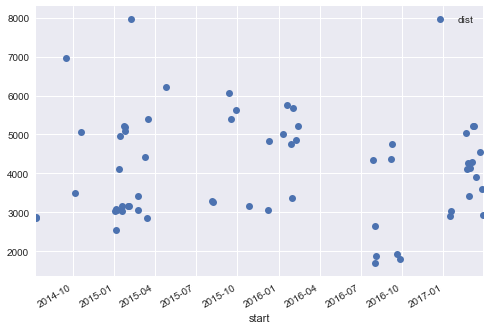

In [2]:
# Build an aggregate dataframe of mean times for each runs
runs = {k:[] for k in ['time', 'dist', 'td', 'start', 't1k']}
for f in glob('activities/*.gpx'):
    data = load_file(f)
    time, dist, td, t1k = get_run_summary(data)
    runs['time'].append(time)
    runs['dist'].append(dist)
    runs['td'].append(td)
    runs['t1k'].append(t1k/60)
    runs['start'].append(data.time.values[0])
runs = pd.DataFrame(runs)

# Simple outlier exclusion
runs = runs[runs.dist<20000]
runs = runs[runs.dist>1000]
runs = runs[runs.t1k<10]


runs.plot(x='start', y='dist', style='o')

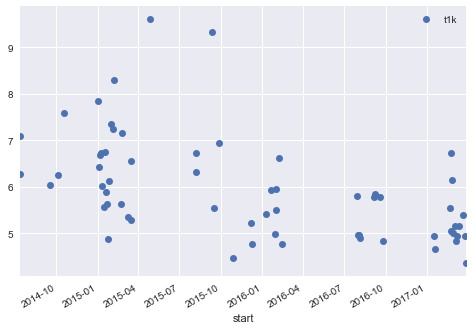

In [3]:
runs.plot(x='start', y='t1k',style='o')